### Stein's Paradoxを実装する
Stein's Paradox...不偏推定量じゃない推定量で平均二乗誤差がより小さい推定量が存在する。

In [1]:
import numpy as np; from tqdm import trange; import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from multiprocessing import Pool;import multiprocessing as multi
import os; os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
def james_stein(X):
    '''
    parameters
    ----------
    X : np.ndarray. X.shape is (n_trial, 3).
    
    returns
    ----------
    theta_js : np.ndarray. james stein estimates. shape is (n_trial, 3)
    
    '''
    return (1-(1/(X**2).sum(axis=1,keepdims=True)))*X

def mse(y_true, y_pred):
    '''
    parameters
    ----------
    y_true : np.ndarray. shape is (1,3)
    y_pred : np.ndarray. shape is (n_trial,3)
    
    returns
    ----------
    mean squared error of each dimension
    (1次元目のmse, 2次元目の平均mse, 3次元目のmse)
    '''
    return ((y_true - y_pred)**2).mean(axis=0)

In [3]:
mu1=[i for i in range(-20,31)]
def _temp_for_multiprocess(arg):
    mu1,n_trial,random_state=arg
    np.random.seed(mu1+100+random_state*100)
    true=np.array([[mu1,3,7]])
    X=np.random.standard_normal(size=(n_trial,3)) + true[0]
    return mse(true,james_stein(X)), mse(true,X)

def get_result(n_trial,random_state):
    '''
    return
    ----------
    result_ub ... unbaised の mu1に対応する各次元の平均二乗誤差
    result_js ... james stein の mu1に対応する各次元の平均二乗誤差
    '''
    result_ub,result_js=[],[]
    args=[(i,n_trial,random_state) for i in mu1]
    #並列処理
    p = Pool(multi.cpu_count()//2)
    result=p.map(_temp_for_multiprocess, args)
    p.close()
    
    result_ub=np.array([x[1] for x in result])
    result_js=np.array([x[0] for x in result])
    
    return result_ub, result_js

### n_trialを更にforで回し回数を稼ぐ

In [4]:
result_ub,result_js=[],[]
for i in trange(300):
    tmp_ub, tmp_js=get_result(5*10**7,random_state=i) #ギリギリメモリに乗る
    result_ub.append(tmp_ub)
    result_js.append(tmp_js)
result_js=np.array(result_js).mean(axis=0)
result_ub=np.array(result_ub).mean(axis=0)

100%|██████████| 300/300 [7:37:42<00:00, 91.43s/it]


### 課題3-1
#### 1.
$1.5 \times 10^{10}$回試行した結果

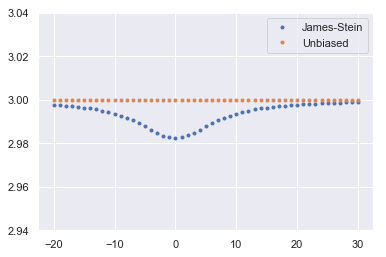

In [5]:
plt.plot(mu1,result_js.sum(axis=1),marker='.',linestyle='None',label='James-Stein')
plt.plot(mu1,result_ub.sum(axis=1),marker='.',linestyle='None',label='Unbiased')
plt.ylim(2.94,3.04)
plt.legend();

#### 2.
$1.5 \times 10^{10}$回試行した結果

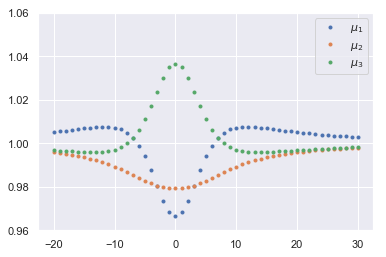

In [6]:
plt.plot(mu1,result_js[:,0],marker='.',linestyle='None',label='$\mu_1$')
plt.plot(mu1,result_js[:,1],marker='.',linestyle='None',label='$\mu_2$')
plt.plot(mu1,result_js[:,2],marker='.',linestyle='None',label='$\mu_3$')
plt.ylim(0.96,1.06)
plt.legend();

### 3. 上記2つの図からわかること

- Steinsパラドックスを満たすような推定量が確かに存在する
- $\mu_1$が0に近づくほど、各次元の推定がよくなったり悪くなったり変動するが、総合的には平均二乗誤差がよくなる方に働く
- $\mu_1$を0に近づけるほど**推定**された$\mu_3$の誤差は大きくなっている。ある特徴量に関して、真の$\mu$が大きくなればなるほど、他の特徴量が0に近づくときは誤差が大きくなるという仮説が考えられる(実験もしたかったが計算時間の都合上断念)